# Cox’s proportional hazard model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from lifelines import CoxPHFitter

Adicionando una semilla para reproductibilidad

In [2]:
np.random.seed(1234)

#### Conjunto de datos
Usando conjunto de datos preprocesados sobre datos de empresas españolas en el período 1999-2020

In [3]:
df = pd.read_csv('./../datasets/arhv_prepro_5.0.csv')
df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
4,19,0,2.0,1.0,0,0,0,0,0,0,...,0.123080,0.117009,0.793149,0.381961,0.942754,0.003329,-0.745527,-0.009753,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,18,16,1.0,0.0,0,0,0,1,0,0,...,0.190463,0.168681,1.046977,0.091520,0.093166,-0.013568,-2.566817,-0.022228,1,9.0
6377,13,13,3.0,0.0,0,0,0,1,0,0,...,0.298466,0.133987,0.314466,0.145075,0.717814,0.065671,-0.155346,-0.015047,1,12.0
6378,11,11,1.0,0.0,0,0,0,1,0,0,...,0.124445,0.065487,0.977181,0.165864,0.017639,-0.008573,-1.151375,-0.043251,1,9.0
6379,9,5,1.0,0.0,0,0,0,0,0,0,...,0.000000,0.000000,0.522243,0.152878,-0.100963,-0.010897,-1.877954,-0.019716,1,15.0


In [4]:
df_train = df
df_test = df.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

print(f"Train dataset stats: {df_train.shape}, Validation datasets stats: {df_val.shape}, Test dataset stats: {df_test.shape}")

Train dataset stats: (4084, 45), Validation datasets stats: (1021, 45), Test dataset stats: (1276, 45)


In [5]:
df_train.head()

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
9,17,0,1.0,1.0,0,0,0,1,0,0,...,0.184629,0.098159,0.508884,0.184394,-0.056303,-0.022431,-3.495778,-0.031419,1,11.0


### Feature transforms

In [6]:
from sklearn.compose import ColumnTransformer
cols = df_train.columns.tolist()
cols.remove('event')
cols.remove('time')

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), cols)],
    remainder='passthrough',
    verbose_feature_names_out=True
)

x_train = preprocessor.fit_transform(df_train).astype('float32')
x_val = preprocessor.transform(df_val).astype('float32')
x_test = preprocessor.transform(df_test).astype('float32')


In [7]:
new_train_df = pd.DataFrame(x_train, columns=df_train.columns)
new_train_df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,-0.790360,-0.452034,-1.096442,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,-0.379241,-0.880603,1.028981,0.775369,-0.282690,-2.494496,2.280533,-0.447454,0.0,21.0
1,-0.790360,0.958419,0.179304,0.046996,3.256113,-0.038044,-0.174906,2.240331,-0.027113,-0.025561,...,0.164375,0.285719,-0.594430,-0.173744,0.139748,0.468677,0.542689,0.832889,0.0,22.0
2,-0.790360,0.182670,0.179304,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,1.451936,1.982524,1.163637,3.246264,2.443549,-0.518906,-1.324733,0.308120,0.0,22.0
3,2.203040,-0.205205,-2.372189,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,2.825306,2.627802,1.716978,0.505657,1.434675,1.182899,0.371237,-0.139544,1.0,14.0
4,1.887946,-0.452034,-1.096442,0.046996,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,0.144289,-0.201500,-0.874989,0.211487,-0.873157,-0.960503,-3.120359,-0.348114,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,2.045493,-0.452034,-1.096442,-21.278576,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,0.523785,0.779459,1.646370,-0.770086,1.912713,-0.374286,-0.697016,-0.205913,1.0,14.0
4080,1.415303,-0.028898,0.179304,-21.278576,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,-0.696780,-0.670114,-0.915361,0.048631,-0.252974,-0.501973,-2.634521,0.414437,1.0,13.0
4081,1.415303,0.182670,-1.096442,-21.278576,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,-0.665295,-0.548376,1.174089,0.838624,1.253677,1.077832,0.508466,0.278440,1.0,18.0
4082,2.045493,0.112147,-1.096442,-21.278576,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,0.182261,0.443652,0.411092,-0.475292,-0.380490,-0.605689,-2.058118,0.095694,1.0,9.0


## Training the model

In [8]:
cph = CoxPHFitter()
cph.fit(new_train_df, duration_col='time', event_col='event')

<lifelines.CoxPHFitter: fitted with 4084 total observations, 2613 right-censored observations>

In [9]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4084 total observations, 2613 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 4084
number of events observed = 1471
   partial log-likelihood = -10848.75
         time fit was run = 2025-10-15 08:10:01 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
N1         0.72      2.05      0.02            0.67            0.76                1.96                2.14
N2        -0.04      0.96      0.03           -0.10            0.02                0.91                1.02
N3        -0.02      0.98      0.04           -0.11            0.07                0.90                1.07
N4        -0.04      0.96      0.02           -0.07           -0.01                0.93                0.99
N5        -0.05      0.95      0.03           -0.11            0.00                0.90                1.00
N6         0.03      1.03      0.02           -0.01            0.07                0.99                1.08
N7        -0.01      0.99      0.03           -0.06            0.04                0.94                1.05
N8         0.11      1.12      0.03            0.06            0.17                1.06                1.19
N9         0.30      1.36     14.39          -27.89           28.50                0.00            2.39e+12
N10       -0.45      0.64     20.35          -40.33           39.43                0.00            1.33e+17
N11        0.01      1.01      0.03           -0.05            0.06                0.95                1.06
N12       -0.00      1.00      0.03           -0.06            0.05                0.94                1.05
N13       -0.00      1.00      0.03           -0.06            0.05                0.94                1.05
N14        0.32      1.38      0.02            0.28            0.36                1.33                1.43
N15       -0.76      0.47      0.05           -0.87           -0.66                0.42                0.52
F16        0.01      1.01      0.03           -0.05            0.06                0.95                1.06
F17        0.01      1.01      0.03           -0.06            0.08                0.95                1.08
F18       -0.14      0.87      0.09           -0.31            0.04                0.73                1.04
F19       -0.03      0.97      0.05           -0.12            0.06                0.88                1.06
F20       -0.46      0.63      0.11           -0.67           -0.25                0.51                0.78
F21        0.73      2.08      0.12            0.49            0.98                1.63                2.66
F22       -0.08      0.92      0.07           -0.23            0.06                0.80                1.06
F23       -0.07      0.93      0.06           -0.18            0.04                0.84                1.04
F24       -0.01      0.99      0.10           -0.20            0.19                0.82                1.21
F25       -0.15      0.86      0.05           -0.24           -0.06                0.78                0.94
F26       -0.24      0.78      0.24           -0.71            0.22                0.49                1.24
F27        0.02      1.02      0.03           -0.03            0.07                0.97                1.08
F28       -0.28      0.76      0.07           -0.41           -0.14                0.67                0.87
F29        0.20      1.22      0.06            0.09            0.32                1.09                1.37
F30        0.01      1.01      0.04           -0.06            0.09                0.94                1.09
F31        0.07      1.08      0.06           -0.04            0.19                0.96                1.21
F32        0.22      1.24      0.25           -0.26            0.70      

## Evaluación del modelo
En la biblioteca lifelines no se calcula explicitamente el indicador **IPCW Brier Score** por lo que es necesario calcularlo manualmente.
El IPCW Brier Score es una métrica de evaluación para modelos de supervivencia que corrige el sesgo introducido por la censura en los datos. El siguiente código ayuda a calcular dicho error:

In [10]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

def ipcw_brier_score(
    model, 
    X, 
    event_times, 
    event_observed, 
    times, 
    train_event_times=None, 
    train_event_observed=None
):
    """
    Calcula el IPCW Brier Score para un modelo CoxPH en tiempos específicos.

    Parámetros:
    - model: instancia entrenada de CoxPHFitter
    - X: DataFrame con covariables de prueba
    - event_times: array con tiempos de evento/censura (datos de prueba)
    - event_observed: array con indicadores de evento (1=event, 0=censored) (datos de prueba)
    - times: array de tiempos en los que evaluar el Brier score
    - train_event_times, train_event_observed: datos de entrenamiento para estimar G(t)
      (si no se pasan, se usan los de prueba, pero idealmente usar entrenamiento)

    Retorna:
    - brier_scores: array con el IPCW Brier Score en cada tiempo de `times`
    """
    if train_event_times is None:
        train_event_times = event_times
        train_event_observed = event_observed

    # Paso 1: Estimar G(t) = supervivencia del censoring
    # Invertimos evento/censura: ahora "evento" = censura
    censoring_event = 1 - train_event_observed
    km_censoring = KaplanMeierFitter()
    km_censoring.fit(train_event_times, event_observed=censoring_event)

    

    # Obtener G(t) para los tiempos necesarios
    G_times = np.concatenate([times, event_times])
    G_times = np.unique(G_times)
    G_vals = km_censoring.survival_function_at_times(G_times).values
    G_dict = dict(zip(G_times, G_vals))

    # Interpolar G(t) para cualquier tiempo (monótono decreciente)
    def G(t):
        # Usar el valor más cercano a la izquierda (step function)
        idx = np.searchsorted(G_times, t, side='right') - 1
        idx = np.clip(idx, 0, len(G_times) - 1)
        return G_dict[G_times[idx]]

    # Vectorizar G
    G_vec = np.vectorize(G)

    # Paso 2: Predecir S(t | X) para cada individuo y cada tiempo
    # lifelines no tiene predict_survival_function para múltiples tiempos directamente,
    # pero podemos usar `predict_survival_function`
    surv_funcs = model.predict_survival_function(X)
    
    # Evaluar en los tiempos deseados
    # S_pred = np.array([fn(times) for fn in surv_funcs])  # shape: (n_samples, n_times)
    S_pred = surv_funcs.loc[times].T.values

    # Paso 3: Calcular IPCW Brier Score
    n_samples = len(event_times)
    brier_scores = []

    for j, t in enumerate(times):
        # Componente 1: individuos con evento antes o en t
        event_mask = (event_times <= t) & (event_observed == 1)
        denom1 = G_vec(event_times[event_mask])
        denom1 = np.clip(denom1, 1e-8, None)  # evitar división por cero
        term1 = np.sum(((0 - S_pred[event_mask, j]) ** 2) / denom1)

        # Componente 2: individuos censurados después de t (o vivos en t)
        censor_mask = (event_times > t)
        denom2 = G_vec(t)
        denom2 = np.clip(denom2, 1e-8, None)
        term2 = np.sum(((1 - S_pred[censor_mask, j]) ** 2) / denom2)

        brier = (term1 + term2) / n_samples
        brier_scores.append(brier)

    return np.array(brier_scores)

In [11]:
new_x_test_df = pd.DataFrame(x_test, columns=df_test.columns)
new_x_test_df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,-0.790360,-0.240466,1.455051,0.046996,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,-0.693441,-0.634655,-1.181250,-0.417089,-1.603370,0.491049,0.507820,0.850750,0.0,22.0
1,3.148325,-0.452034,0.179304,0.046996,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,1.457811,1.962773,0.529018,-0.009507,0.468741,0.226620,0.654606,1.034008,1.0,11.0
2,-0.790360,8.081208,-1.096442,0.046996,3.256113,-0.038044,1.803804,-0.937135,-0.027113,-0.025561,...,-0.703100,-0.651139,1.422336,2.268379,2.047175,0.828466,0.372587,-0.048347,0.0,22.0
3,0.470019,-0.169943,1.455051,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,1.926917,0.175937,-0.822257,-0.258970,-0.867303,-0.155216,-0.331869,-0.899249,0.0,21.0
4,1.572851,-0.452034,1.455051,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,-0.236227,-0.049014,-0.550372,-0.177007,-0.672304,-0.156275,-0.158330,0.530562,1.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,-0.790360,0.112147,0.179304,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,-0.179555,-0.210277,-1.363631,0.139021,-1.937534,-0.376358,-0.203461,0.349309,0.0,22.0
1272,0.154924,-0.452034,1.455051,0.046996,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,0.755627,1.448824,-0.457609,0.902902,0.702749,-0.472754,-0.660980,0.137145,0.0,22.0
1273,-0.790360,0.676329,-1.096442,0.046996,-0.307115,-0.038044,-0.174906,0.651598,-0.027113,-0.025561,...,-0.871889,-0.863233,-0.057302,0.566518,-0.667095,-0.708403,-0.182164,-1.443242,0.0,22.0
1274,-0.790360,-0.452034,-1.096442,0.046996,-0.307115,-0.038044,-0.174906,-0.937135,-0.027113,-0.025561,...,0.227702,0.706550,-0.955629,-1.152055,-0.620798,-0.381645,0.876966,1.203461,1.0,9.0


In [12]:
# Preparar datos de test
X_test = new_x_test_df.drop(["time", "event"], axis=1)
# X_test = new_x_test_df.copy()
T_test = new_x_test_df["time"].values
E_test = new_x_test_df["event"].values

# Tiempos en los que evaluar
times = np.percentile(T_test[E_test == 1], np.linspace(10, 90, 9))  # solo eventos
times

array([10., 11., 13., 14., 14., 15., 16., 17., 19.])

In [13]:
surv_funcs = cph.predict_survival_function(X_test)
print(type(surv_funcs))
print(type(surv_funcs[0]))  # Deben ser pandas.Series
print(surv_funcs[0].head())  # Muestra los primeros tiempos y probabilidades
# Evaluar en los tiempos deseados
# S_pred = np.array([fn(times) for fn in surv_funcs])  # shape: (n_samples, n_times)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
3.0    0.999147
4.0    0.997293
5.0    0.993669
6.0    0.990352
7.0    0.985014
Name: 0, dtype: float64


In [14]:
# Calcular IPCW Brier Score
brier_scores = ipcw_brier_score(
    model=cph,
    X=X_test,
    event_times=T_test,
    event_observed=E_test,
    times=times,
    train_event_times=df_train["time"].values,
    train_event_observed=df_train["event"].values
)

print("Tiempos:", times)
print("IPCW Brier Scores:", np.mean(brier_scores))

Tiempos: [10. 11. 13. 14. 14. 15. 16. 17. 19.]
IPCW Brier Scores: 0.11318854084280044


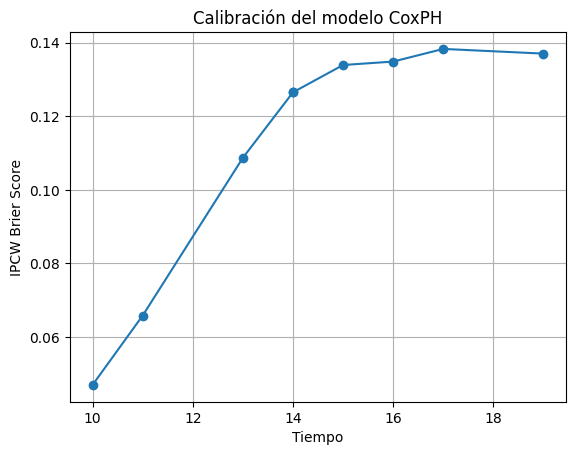

In [15]:
import matplotlib.pyplot as plt

plt.plot(times, brier_scores, marker='o')
plt.xlabel('Tiempo')
plt.ylabel('IPCW Brier Score')
plt.title('Calibración del modelo CoxPH')
plt.grid(True)
plt.show()

#### Calculando el valor **IPCW-weighted negative log-likelihood**

In [16]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter

def ipcw_negative_log_likelihood(
    model,
    X,
    event_times,
    event_observed,
    train_event_times=None,
    train_event_observed=None
):
    """
    Calcula el IPCW-weighted negative log-likelihood para un modelo CoxPH.

    Parámetros:
    - model: instancia entrenada de CoxPHFitter
    - X: DataFrame con covariables (mismo formato que en fit)
    - event_times: array de tiempos (T_i)
    - event_observed: array de indicadores de evento (δ_i)
    - train_event_times, train_event_observed: datos de entrenamiento para estimar G(t)

    Retorna:
    - ipcw_nll: float, el IPCW negative log-likelihood (menor es mejor)
    """
    if train_event_times is None:
        train_event_times = event_times
        train_event_observed = event_observed

    # 1. Estimar G(t) = supervivencia del censoring
    censoring_event = 1 - train_event_observed
    km_censoring = KaplanMeierFitter()
    km_censoring.fit(train_event_times, event_observed=censoring_event)

    # Obtener G(T_i) para cada sujeto
    G_Ti = km_censoring.survival_function_at_times(event_times).values
    G_Ti = np.clip(G_Ti, 1e-8, None)  # evitar división por cero

    # 2. Obtener predicciones del modelo Cox
    # a) Riesgo lineal: η = β^T X
    linear_predictor = model.predict_log_partial_hazard(X).values  # shape: (n,)
    partial_hazard = np.exp(linear_predictor)  # exp(β^T X)

    # b) Supervivencia en T_i: S(T_i | X_i)
    surv_funcs = model.predict_survival_function(X)
    # S_Ti = np.array([fn(t) for fn, t in zip(surv_funcs, event_times)])
    # S_Ti = surv_funcs.loc[event_times].T.values.diagonal()  # Extraer la diagonal
    S_Ti = np.array([np.interp(t, surv_funcs.index, surv_funcs.iloc[:, i]) for i, t in enumerate(event_times)])

    # c) Riesgo base en T_i: h0(T_i)
    # lifelines guarda la baseline hazard en model.baseline_hazard_
    baseline_hazard = model.baseline_hazard_
    # Interpolar h0(t) en event_times (step function: usar último valor <= t)
    h0_Ti = np.array([
        baseline_hazard.loc[:t].iloc[-1, 0] if t >= baseline_hazard.index.min() else baseline_hazard.iloc[0, 0]
        for t in event_times
    ])

    # d) Riesgo individual: h(T_i | X_i) = h0(T_i) * exp(β^T X_i)
    h_Ti = h0_Ti * partial_hazard

    # e) Densidad: f(T_i | X_i) = h(T_i | X_i) * S(T_i | X_i)
    f_Ti = h_Ti * S_Ti

    # 3. Calcular log-verosimilitud ponderada
    log_likelihood = np.zeros_like(event_times, dtype=float)

    # Eventos observados
    event_mask = (event_observed == 1)
    if np.any(event_mask):
        f_event = f_Ti[event_mask]
        f_event = np.clip(f_event, 1e-15, None)  # evitar log(0)
        log_likelihood[event_mask] = np.log(f_event)

    # Censurados
    censor_mask = (event_observed == 0)
    if np.any(censor_mask):
        S_censor = S_Ti[censor_mask]
        S_censor = np.clip(S_censor, 1e-15, None)
        log_likelihood[censor_mask] = np.log(S_censor)

    # Aplicar pesos IPCW
    weighted_loglik = (log_likelihood / G_Ti)

    # Negative log-likelihood promedio
    ipcw_nll = -np.mean(weighted_loglik)

    return ipcw_nll

new_train_df, duration_col='time', event_col='event'

In [17]:
# Suponiendo que ya tienes:
# - cph: modelo CoxPHFitter entrenado
# - X_test, T_test, E_test: datos de prueba

nll = ipcw_negative_log_likelihood(
    model=cph,
    X=X_test,
    event_times=T_test,
    event_observed=E_test,
    train_event_times=new_train_df['time'].values,
    train_event_observed=new_train_df['event'].values
)

print(f"IPCW Negative Log-Likelihood: {nll:.4f}")

IPCW Negative Log-Likelihood: 17.4914


### Predicting new cases

In [18]:
df_to_predict = pd.read_csv('./../datasets/to_predict.csv')

In [19]:
predict_surv_funct = cph.predict_survival_function(df_to_predict)
predict_surv_funct

,0,1,2
3.0,0.0,0.992423,1.0
4.0,0.0,0.976132,1.0
5.0,0.0,0.944970,1.0
6.0,0.0,0.917221,1.0
7.0,0.0,0.874090,1.0
8.0,0.0,0.821774,1.0
9.0,0.0,0.786242,1.0
10.0,0.0,0.704189,1.0
11.0,0.0,0.582124,1.0
12.0,0.0,0.473007,1.0


In [20]:
cph.predict_median(df_to_predict)

0     3.0
1    12.0
2     inf
Name: 0.5, dtype: float64

In [21]:
cph.predict_partial_hazard(df_to_predict)

0    3.888006e+17
1    1.307099e+01
2    6.159298e-07
dtype: float64

### Salvando el modelo en disco

In [30]:
import joblib
joblib.dump(preprocessor, './coxph_models/preprocessor.joblib')
joblib.dump(cph, './coxph_models/coxph_model.joblib')

['./coxph_models/coxph_model.joblib']

In [31]:

preprocessor_loaded = joblib.load('./coxph_models/preprocessor.joblib')
cph_loaded = joblib.load('./coxph_models/coxph_model.joblib')

In [32]:
# preprocess new cases
from sklearn.compose import ColumnTransformer
cols = df_to_predict.columns.tolist()
cols.remove('event')
cols.remove('time')

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), cols)],
    remainder='passthrough',
    verbose_feature_names_out=True
)

x_to_predict = preprocessor.fit_transform(df_to_predict).astype('float32')

new_to_predict_df = pd.DataFrame(x_to_predict, columns=df_to_predict.columns)

predict_surv_funct = cph_loaded.predict_survival_function(new_to_predict_df)
predict_surv_funct

,0,1,2
3.0,0.998423,0.999891,0.998852
4.0,0.995001,0.999655,0.996359
5.0,0.988327,0.999191,0.991490
6.0,0.982235,0.998766,0.987038
7.0,0.972469,0.998078,0.979885
8.0,0.960098,0.997198,0.970796
9.0,0.951334,0.996568,0.964339
10.0,0.929829,0.994999,0.948423
11.0,0.893825,0.992295,0.921549
12.0,0.856153,0.989355,0.893114


In [40]:
bl = cph.baseline_survival_
bl

,baseline survival
3.0,0.999418
4.0,0.998154
5.0,0.995679
6.0,0.993411
7.0,0.989757
8.0,0.985095
9.0,0.981769
10.0,0.973526
11.0,0.959450
12.0,0.944334


<Figure size 800x500 with 0 Axes>

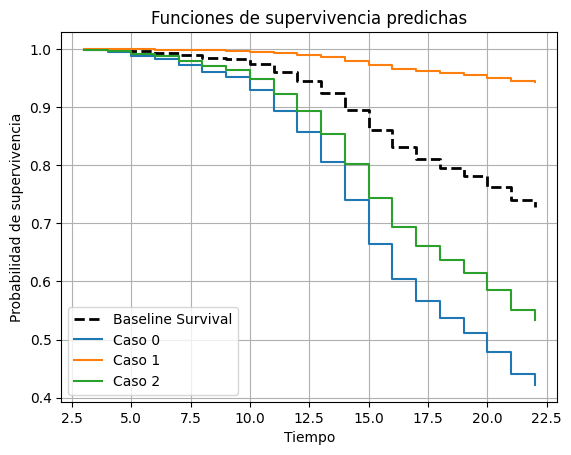

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
fig,ax = plt.subplots()
ax.step(
    bl.index, 
    bl['baseline survival'], 
    where='post',
    label='Baseline Survival', 
    linestyle='--', 
    linewidth=2,
    color='black'
)
for i in predict_surv_funct.columns:
    ax.step(predict_surv_funct.index, predict_surv_funct[i], where='post', label=f'Caso {i}')
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de supervivencia')
plt.title('Funciones de supervivencia predichas')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
median = cph.predict_median(new_to_predict_df)
median

0    20.0
1     inf
2     inf
Name: 0.5, dtype: float64

In [36]:
cph.predict_partial_hazard(new_to_predict_df)

0    2.711567
1    0.186857
2    1.973651
dtype: float64